In [108]:
# Load the Drive helper and mount
from google.colab import drive
import os

# This will prompt for authorization.
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
os.chdir('/content/drive/My Drive/USED/Humana')
# os.listdir('Data')

In [110]:
!pip install pytorch_tabnet
!pip install catboost
!pip install scikit-learn==1.0


In [111]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# DataData Cleaning

In [112]:
import pandas as pd 
import numpy as np 
df_train=pd.read_csv('Data/2021_Competition_Training.csv',nrows=1000) # toy data
df_train_zip=pd.read_csv('Data/train_zip_enc_cluster.csv',nrows=1000)
df_train=pd.concat((df_train,df_train_zip),axis=1)

del df_train_zip
df_train.drop(['zip_cd','Unnamed: 0','ID'],axis=1,inplace=True)

df_train=reduce_mem_usage(df_train)
df_train['covid_vaccination']=(df_train['covid_vaccination']=='vacc').astype(int)


df_test=pd.read_csv('Data/2021_Competition_Holdout.csv',nrows=1000) # toy data
df_test_zip=pd.read_csv('Data/test_zip_enc_cluster.csv',nrows=1000)
df_test=pd.concat((df_test,df_test_zip),axis=1)


del df_test_zip
df_test.drop(['zip_cd','Unnamed: 0','ID'],axis=1,inplace=True)

df_test=reduce_mem_usage(df_test)

df=pd.concat((df_train,df_test))

del df_train, df_test


target='covid_vaccination'

display(df.head())
df.info()

Mem. usage decreased to  1.07 Mb (66.4% reduction)
Mem. usage decreased to  1.06 Mb (66.5% reduction)


,auth_3mth_post_acute_dia,rx_gpi2_72_pmpm_cost_6to9m_b4,atlas_pct_laccess_child15,atlas_recfacpth14,atlas_pct_fmrkt_frveg16,atlas_pct_free_lunch14,bh_ip_snf_net_paid_pmpm_cost_9to12m_b4,auth_3mth_acute_ckd,bh_ncal_pmpm_ct,src_div_id,total_bh_copay_pmpm_cost_t_9-6-3m_b4,bh_ip_snf_net_paid_pmpm_cost_3to6m_b4,cons_chmi,mcc_ano_pmpm_ct_t_9-6-3m_b4,auth_3mth_post_acute_trm,rx_maint_pmpm_cost_t_12-9-6m_b4,auth_3mth_post_acute_rsk,cons_ltmedicr,rx_gpi4_6110_pmpm_ct,atlas_pc_snapben15,credit_bal_nonmtgcredit_60dpd,rx_bh_mbr_resp_pmpm_cost_9to12m_b4,rx_nonbh_pmpm_cost_t_9-6-3m_b4,atlas_pct_laccess_nhna15,auth_3mth_acute_vco,credit_hh_nonmtgcredit_60dpd,rx_bh_pmpm_ct_0to3m_b4,auth_3mth_dc_ltac,cons_lwcm10,auth_3mth_post_acute_inj,atlas_fsrpth14,auth_3mth_dc_home,atlas_wicspth12,rx_gpi2_17_pmpm_cost_t_12-9-6m_b4,cons_hxmioc,rx_generic_pmpm_cost_t_6-3-0m_b4,cmsd2_sns_digest_abdomen_pmpm_ct,atlas_ghveg_farms12,credit_hh_bankcardcredit_60dpd,total_outpatient_allowed_pmpm_cost_6to9m_b4,...,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0,0.000000,7.910156,0.049408,0.00,46.84375,0.0,0,0.0,000,No Activity,0.0,67.0,No Activity,0,Inc_1x-2x,0,4.0,0.0,8.070312,2366.0,0.000000,Dec_1x-2x,0.036560,0,22.609375,0.0,0,0.267090,0,0.904297,0,0.248291,No Activity,9.0,Dec_1x-2x,0.0,5.0,9.804688,0.0,...,NaN,0.199951,NaN,NaN,NaN,NaN,0.199951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.199951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0.000000,1.730469,0.095642,60.00,36.71875,NaN,0,0.0,000,No Activity,0.0,69.0,No Activity,0,No Activity,0,3.0,0.0,12.351562,2926.0,0.000000,New,0.028854,0,19.625000,0.0,0,0.142700,0,0.721680,0,0.087830,No Activity,9.0,Inc_over_8x,0.0,6.0,10.078125,0.0,...,NaN,0.199951,NaN,NaN,NaN,NaN,0.199951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.199951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0.000000,5.015625,0.022400,30.00,39.59375,0.0,0,0.0,000,No Activity,0.0,76.0,No Activity,0,Dec_2x-4x,0,NaN,0.0,14.187500,4524.0,0.170044,New,0.086731,0,36.281250,0.0,0,0.259033,0,0.444336,0,0.103271,No Activity,3.0,Inc_1x-2x,0.0,1.0,15.609375,4192.0,...,NaN,0.199951,NaN,NaN,NaN,NaN,0.199951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.199951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2.267578,4.050781,0.070435,50.00,93.68750,0.0,0,0.0,000,No Activity,0.0,46.0,No Activity,0,Inc_1x-2x,0,8.0,0.0,25.218750,3994.0,0.000000,Dec_1x-2x,0.166992,0,34.031250,0.0,0,0.279541,0,0.696777,0,0.087036,No Activity,6.0,New,0.0,0.0,22.734375,0.0,...,NaN,0.199951,NaN,NaN,NaN,NaN,0.199951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.199951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0.000000,0.618652,0.074890,88.25,36.31250,0.0,0,0.0,000,No Activity,0.0,111.0,No Activity,0,Inc_1x-2x,0,4.0,0.0,2.080078,1337.0,0.000000,Inc_2x-4x,0.035950,0,11.664062,0.0,0,0.267090,0,0.759277,0,0.160400,Resolved,8.0,Dec_1x-2x,0.0,17.0,7.175781,0.0,...,NaN,0.199951,NaN,NaN,NaN,NaN,0.199951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.199951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 999
Columns: 415 entries, auth_3mth_post_acute_dia to 49
dtypes: float16(259), float32(6), float64(1), int16(4), int8(84), object(61)
memory usage: 2.2+ MB


## Seperate numeric feature and categorical feature

In [113]:
# cat fea but type is int
cat_feas=['bh_ncal_ind', 'bh_ncdm_ind']    

# num fea but type is str
num_feas=['rx_gpi2_34_dist_gpi6_pmpm_ct','rx_gpi2_33_pmpm_ct_0to3m_b4','src_div_id',
              'lab_albumin_loinc_pmpm_ct','ccsp_065_pmpm_ct','rev_cms_ansth_pmpm_ct',
              'rej_total_physician_office_visit_ct_pmpm_0to3m_b4','rx_gpi2_90_dist_gpi6_pmpm_ct_9to12m_b4',
              'rx_gpi2_56_dist_gpi6_pmpm_ct_3to6m_b4','rx_gpi2_72_pmpm_ct_6to9m_b4','rx_bh_pmpm_ct_0to3m_b4','rx_gpi4_6110_pmpm_ct']

for col in df.columns:
    if col !=target:
        dtype=df[col].dtype
        if col in num_feas:
            if dtype!=np.dtype('float16'):
                df[col]=df[col].replace('*',None).astype(float)
        if col not in num_feas+cat_feas+[target]:
            if dtype=='O':
                cat_feas.append(col)
            else:
                num_feas.append(col)

cat_feas=[x for x in cat_feas if 'zip_cd' not in x]
num_feas=[x for x in num_feas if 'zip_cd' not in x]


for col in num_feas+cat_feas:
    if col in cat_feas:
        if df[col].isnull().sum():
            df[col]=df[col].fillna('null')
        df[col]=df[col].astype(str).astype('category')#.cat.codes
    else:
        m=df[col].astype(float).mean()
        df[col]=df[col].fillna(m)

# PCA

In [114]:
from sklearn.decomposition import PCA
n_comp=100

pca = PCA(n_components=n_comp)
pca.fit(df[num_feas])

df_pca_num=pd.DataFrame(pca.transform(df[num_feas]))


In [115]:
from sklearn.decomposition import PCA
n_comp=100

pca = PCA(n_components=n_comp)
pca.fit(df[num_feas])

df_pca_num=pd.DataFrame(pca.transform(df[num_feas]))

# recover feature names
most_important = []

comps=pca.components_
for i in range(n_comp):
    ind_max=np.abs(comps[i]).argmax()
    comps[:,ind_max]=0
    most_important.append(ind_max)

most_important_names = [num_feas[most_important[i]] for i in range(n_comp)]
df_pca_num.columns=most_important_names


# one hot
df_cat_oh=pd.get_dummies(df[cat_feas],drop_first=True).reset_index()
df_cat_oh.drop('index',axis=1,inplace=True)

df_pca_num.columns=most_important_names

df_cat_oh=pd.get_dummies(df[cat_feas],drop_first=True).reset_index()
df_cat_oh.drop('index',axis=1,inplace=True)

# update feature columns
num_feas=df_pca_num.columns.tolist()
cat_feas=df_cat_oh.columns.tolist()


# merge data
df_new=pd.concat((df_pca_num,df_cat_oh),axis=1)

df_new=pd.concat((df_new,df[[target]].reset_index()),axis=1)
df_new.drop('index',axis=1,inplace=True)

del df
print(df_new.shape)

df_train=df_new[~df_new[target].isnull()]
df_test=df_new[df_new[target].isnull()]

del df_new

df_train.to_csv('Data/train_pca_clean.csv',index=False)
df_test.to_csv('Data/test_pca_clean.csv',index=False)

display(df_train.head())
display(df_test.head())


(2000, 565)


,atlas_totalocchu,atlas_agritrsm_rct12,cons_estinv30_rc,cons_nwperadult,atlas_redemp_snaps16,atlas_medhhinc,credit_bal_mtgcredit_new,atlas_percapitainc,credit_bal_autobank,rx_overall_net_paid_pmpm_cost_6to9m_b4,total_med_allowed_pmpm_cost_9to12m_b4,credit_bal_nonmtgcredit_60dpd,total_outpatient_allowed_pmpm_cost_6to9m_b4,credit_bal_autofinance_new,rx_nonbh_net_paid_pmpm_cost,credit_bal_consumerfinance,atlas_ghveg_sqftpth12,atlas_orchard_farms12,rej_days_since_last_clm,rx_days_since_last_script,rx_nonbh_mbr_resp_pmpm_cost_6to9m_b4,credit_bal_bankcard_severederog,rx_generic_pmpm_cost_6to9m_b4,cms_tot_partd_payment_amt,cons_chva,atlas_pc_fsrsales12,rx_gpi2_72_pmpm_cost_6to9m_b4,atlas_pc_ffrsales12,rx_nonmaint_mbr_resp_pmpm_cost_9to12m_b4,rx_generic_pmpm_cost,atlas_pct_fmrkt_otherfood16,rx_overall_mbr_resp_pmpm_cost_0to3m_b4,atlas_dirsales_farms12,rx_days_since_last_script_6to9m_b4,total_outpatient_mbr_resp_pmpm_cost_6to9m_b4,rx_maint_mbr_resp_pmpm_cost_6to9m_b4,med_physician_office_ds_clm_6to9m_b4,rx_overall_mbr_resp_pmpm_cost,atlas_pct_fmrkt_sfmnp16,atlas_recfac14,...,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4_Dec_over_8x,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4_Inc_1x-2x,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4_Inc_2x-4x,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4_Inc_4x-8x,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4_Inc_over_8x,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4_New,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4_No Activity,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4_No_Change,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4_Resolved,bh_ip_snf_admit_days_pmpm_t_9-6-3m_b4_No_Change,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4_Dec_2x-4x,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4_Dec_4x-8x,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4_Inc_1x-2x,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4_Inc_2x-4x,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4_Inc_4x-8x,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4_New,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4_No Activity,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4_No_Change,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4_Resolved,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_Dec_2x-4x,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_Dec_4x-8x,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_Inc_1x-2x,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_Inc_2x-4x,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_Inc_4x-8x,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_New,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_No Activity,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_No_Change,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_Resolved,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Dec_2x-4x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Dec_4x-8x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Dec_over_8x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Inc_1x-2x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Inc_2x-4x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Inc_4x-8x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Inc_over_8x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_New,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_No Activity,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_No_Change,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Resolved,covid_vaccination
0,-154157.343398,7.148032e+04,73908.159205,-30768.004085,-74460.274072,4897.704813,-2283.723072,1644.698370,960.282697,-334.567457,-364.690241,-148.116999,-144.659173,-427.266267,108.806250,98.865952,20.817176,27.374993,-64.277670,90.342134,-77.958759,-62.909996,32.276309,-123.507038,41.838488,46.009710,-5.523989,49.943871,-105.742561,-45.444784,80.114575,23.913409,75.268278,-18.920705,-13.915409,-22.539206,-14.139247,0.251808,0.001183,2.360957,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0
1,-77036.306823,8.464765e+03,-718074.734922,-135846.516194,16101.849899,-1437.852402,2205.955352,1169.313558,1335.543390,-86.719545,146.226721,727.861259,-275.099491,-587.448289,125.084758,58.036090,-3.308797,4.706052,-98.638849,88.021205,-53.268556,-57.441273,-30.512695,-79.138878,48.803254,-94.629533,14.161771,75.097066,-42.499085,46.832695,18.603243,-51.216305,-60.62

,atlas_totalocchu,atlas_agritrsm_rct12,cons_estinv30_rc,cons_nwperadult,atlas_redemp_snaps16,atlas_medhhinc,credit_bal_mtgcredit_new,atlas_percapitainc,credit_bal_autobank,rx_overall_net_paid_pmpm_cost_6to9m_b4,total_med_allowed_pmpm_cost_9to12m_b4,credit_bal_nonmtgcredit_60dpd,total_outpatient_allowed_pmpm_cost_6to9m_b4,credit_bal_autofinance_new,rx_nonbh_net_paid_pmpm_cost,credit_bal_consumerfinance,atlas_ghveg_sqftpth12,atlas_orchard_farms12,rej_days_since_last_clm,rx_days_since_last_script,rx_nonbh_mbr_resp_pmpm_cost_6to9m_b4,credit_bal_bankcard_severederog,rx_generic_pmpm_cost_6to9m_b4,cms_tot_partd_payment_amt,cons_chva,atlas_pc_fsrsales12,rx_gpi2_72_pmpm_cost_6to9m_b4,atlas_pc_ffrsales12,rx_nonmaint_mbr_resp_pmpm_cost_9to12m_b4,rx_generic_pmpm_cost,atlas_pct_fmrkt_otherfood16,rx_overall_mbr_resp_pmpm_cost_0to3m_b4,atlas_dirsales_farms12,rx_days_since_last_script_6to9m_b4,total_outpatient_mbr_resp_pmpm_cost_6to9m_b4,rx_maint_mbr_resp_pmpm_cost_6to9m_b4,med_physician_office_ds_clm_6to9m_b4,rx_overall_mbr_resp_pmpm_cost,atlas_pct_fmrkt_sfmnp16,atlas_recfac14,...,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4_Dec_over_8x,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4_Inc_1x-2x,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4_Inc_2x-4x,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4_Inc_4x-8x,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4_Inc_over_8x,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4_New,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4_No Activity,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4_No_Change,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4_Resolved,bh_ip_snf_admit_days_pmpm_t_9-6-3m_b4_No_Change,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4_Dec_2x-4x,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4_Dec_4x-8x,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4_Inc_1x-2x,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4_Inc_2x-4x,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4_Inc_4x-8x,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4_New,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4_No Activity,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4_No_Change,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4_Resolved,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_Dec_2x-4x,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_Dec_4x-8x,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_Inc_1x-2x,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_Inc_2x-4x,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_Inc_4x-8x,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_New,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_No Activity,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_No_Change,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_Resolved,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Dec_2x-4x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Dec_4x-8x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Dec_over_8x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Inc_1x-2x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Inc_2x-4x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Inc_4x-8x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Inc_over_8x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_New,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_No Activity,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_No_Change,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Resolved,covid_vaccination
1000,-180029.078930,37843.243243,-19086.041758,2120.768726,-65166.423180,-10300.919671,388.290054,550.361416,-1264.284326,2959.064209,-1285.344946,-653.444782,12.120768,-484.373823,-1106.034676,-308.226047,-4.997919,38.803494,273.464756,-112.490973,243.485291,241.482996,-302.827631,-27.385807,49.313906,87.098343,19.959368,-71.454380,37.850946,99.206402,-30.858026,2.080914,-36.522925,-3.116209,0.226700,59.238058,-16.590283,-17.484576,-14.583381,-41.195127,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
1001,-201054.456844,-93699.140058,-47926.971257,6298.396215,37337.239819,1873.609209,-241.282638,-3888.956140,-188.311603,-457.335388,-288.089031,-806.900504,-208.878329,-768.885635,224.979632,90.566863,-42.786553,97.958568,-58.453426,181.266704,20.385087,111.790896,-182.706104,126.477753,1.338720,-27.416243,-7.794105,66.744506,-87.184303,5.350500,29.786528,4.

# modeling

In [116]:
import numpy as np
import pandas as pd 
pos_ind=df_train[df_train[target]==1].index.tolist()
neg_ind=df_train[df_train[target]==0].index.tolist()

np.random.shuffle(neg_ind)

neg_inds=[]

# build sub dataset
for i in range(5):
    neg_inds.append(neg_ind[len(pos_ind)*i:len(pos_ind)*(i+1)])

In [117]:
from catboost import CatBoostClassifier, Pool,EShapCalcType, EFeaturesSelectionAlgorithm
import pickle
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
import torch 

from sklearn.metrics import average_precision_score,f1_score,accuracy_score,roc_curve,auc
from IPython.display import clear_output


tabnet_params = dict(n_d=24, n_a=24, gamma=1.3,
                        optimizer_fn=torch.optim.Adam, # tabnet package is based on torch, so tf.keras.optimizers.Adam will lead to an error
                        optimizer_params=dict(lr=1e-2),
                        scheduler_params=dict(mode="min",
                                            patience=5,
                                            min_lr=1e-5,
                                            factor=0.9,),
                        scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,   # same, here we can't use tf.keras.callbacks.ReduceLROnPlateau,
                        verbose=5,
                        cat_idxs=range(len(num_feas),len(num_feas+cat_feas))
                        )

def tabnet():
    X_train=train_data.values
    y_train=train_labels.values
    
    X_test=test_data.values
    y_test=test_labels.values

    model = TabNetClassifier(**tabnet_params)

    # tabnet take raw data as input, we don't need min/max scale
    model.fit(X_train=X_train,
                y_train=y_train,
                eval_set=[(X_test, y_test)],
                eval_name=["val"],
                eval_metric=['accuracy','auc'],
                # max_epochs=1,
                max_epochs=250,
                patience=15, 
                # batch_size=512, 
                # virtual_batch_size=64,
                # loss_fn=torch.nn.functional.binary_cross_entropy,
                ) 

    # torch.save(model, 'Model/tabnet_%s_%s.pt'%(i,fold))
    pickle.dump(model, open('Model/tabnet_%s_%s.pt'%(i,fold), 'wb'))
    
    preds_class = model.predict_proba(X_test)
    np.save('Data/tab_test_%s_%s.npy'%(i,fold),preds_class[:,1])

    return model

In [118]:
def catboost():
    catboost_pool = Pool(test_data, 
                                    test_labels,
                                    cat_features=cat_feas,
                                        )

    model_cat = CatBoostClassifier(
                                iterations=1500,
                                learning_rate=0.1,
                                cat_features=cat_feas,
                                # cat_features=imp_cat,
                                task_type="GPU",
                                early_stopping_rounds=100,
                                depth=4,
                                # eval_metric=['AUC','F1','Accuracy'],
                                # loss_function='Logloss',
                                # verbose=False,
                                verbose=100,
                                )

    # train the model_cat
    model_cat.fit(train_data, train_labels,eval_set=catboost_pool,use_best_model=True)

    pickle.dump(model_cat, open('Model/catboost_red_%s'%i, 'wb'))

    preds_class = model_cat.predict_proba(test_data)
    np.save('Data/cat_test_%s_%s.npy'%(i,fold),preds_class[:,1])

    ev=model_cat.eval_metrics(catboost_pool,['AUC','F1','Accuracy'])

    res=[]
    for key in ev.keys():
        res.append([key,max(ev[key]),ev[key][-1]])

    display(pd.DataFrame(res,columns=['metirc','max','last']))
    return model_cat

In [119]:
# %%time
df_train[target]=df_train[target].astype(int)
folds=5

res=[]
model_tabs=[]
model_cats=[]

for i,neg_ind in enumerate(neg_inds):

    print('\n\n','#'*30,'subset',i,'#'*30,'\n')
    df_sub_dataset=df_train.loc[pos_ind+neg_ind]
    
    # shuffle data
    df_sub_dataset['ran']=[np.random.random() for _ in range(len(df_sub_dataset))]
    df_sub_dataset=df_sub_dataset.sort_values('ran').reset_index()
    df_sub_dataset.drop(['ran','index'],axis=1,inplace=True)

    for fold in range(folds):
        ######################################## prepare data ######################################### 
        sample_in_fold=len(df_sub_dataset)//folds

        df_sub_dataset_test=df_sub_dataset.iloc[sample_in_fold*fold:sample_in_fold*(fold+1)]
        df_sub_dataset_train=df_sub_dataset.loc[set(df_sub_dataset.index)-set(df_sub_dataset_test.index)]

        train_data=df_sub_dataset_train[num_feas+cat_feas]
        train_labels=df_sub_dataset_train[target]
        test_data=df_sub_dataset_test[num_feas+cat_feas]
        test_labels=df_sub_dataset_test[target]
        
        test_labels.to_csv('Data/subset_cv_test_label_%s_%s.csv'%(i,fold),index=False)

        ######################################## TabNet ########################################
        model_tabs.append(tabnet())

        ######################################## CatBoost ########################################
        model_cats.append(catboost())

        break
    break



 ############################## subset 0 ############################## 

Device used : cuda
epoch 0  | loss: 1.07939 | val_accuracy: 0.4697  | val_auc: 0.52068 |  0:00:00s
epoch 5  | loss: 0.91832 | val_accuracy: 0.54545 | val_auc: 0.5094  |  0:00:00s
epoch 10 | loss: 0.77316 | val_accuracy: 0.56061 | val_auc: 0.44173 |  0:00:00s
epoch 15 | loss: 0.67817 | val_accuracy: 0.56061 | val_auc: 0.51786 |  0:00:01s

Early stopping occurred at epoch 17 with best_epoch = 2 and best_val_auc = 0.62406
Best weights from best epoch are automatically used!


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.6785207	test: 0.6886109	best: 0.6886109 (0)	total: 44.1ms	remaining: 1m 6s
100:	learn: 0.1907193	test: 0.7109217	best: 0.6827241 (10)	total: 4.13s	remaining: 57.3s
bestTest = 0.6827240568
bestIteration = 10
Shrink model to first 11 iterations.


,metirc,max,last
0,AUC,0.584586,0.584586
1,F1,0.703297,0.459016
2,Accuracy,0.590909,0.500000


# Interpretable Machine Learning

In [174]:
pip install shap


     |████████████████████████████████| 564 kB 5.4 MB/s 


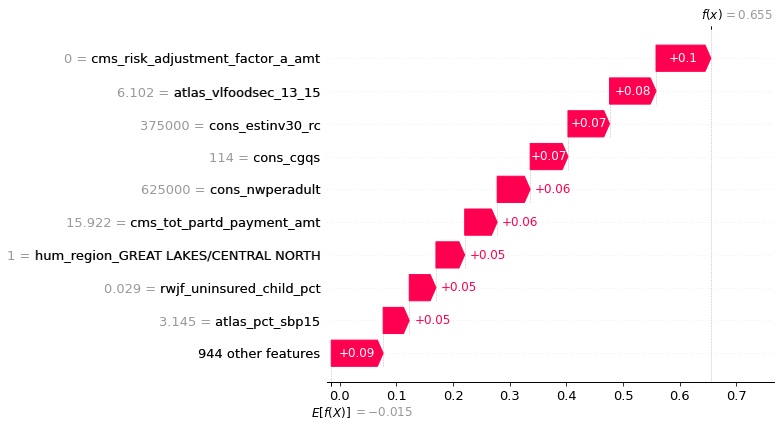

In [ ]:
import shap

explainer = shap.Explainer(model_cats[0])
shap_values = explainer(test_data.iloc[:10000])

shap.plots.waterfall(shap_values[0])

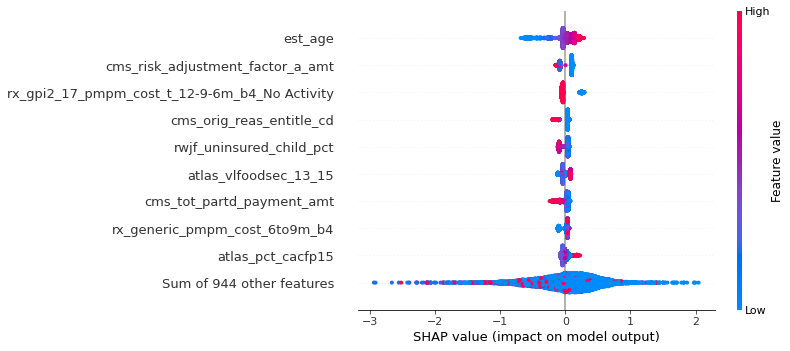

In [ ]:
shap.initjs()
shap.plots.beeswarm(shap_values)

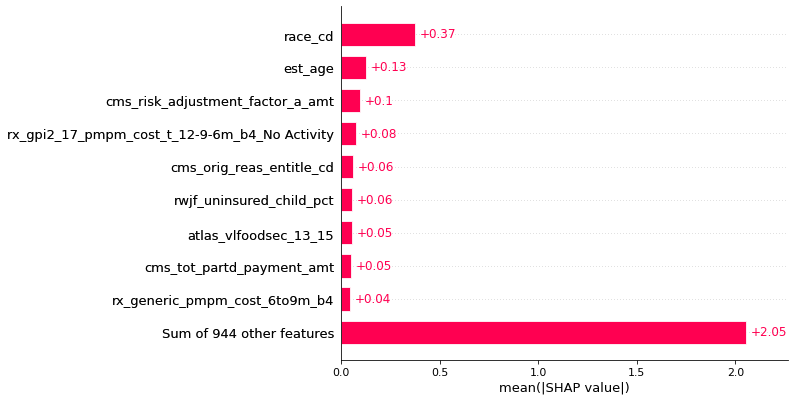

In [ ]:
shap.initjs()
shap.plots.bar(shap_values)

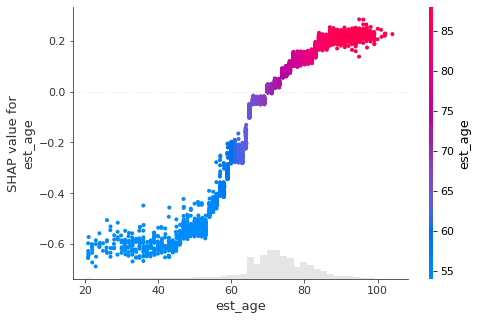

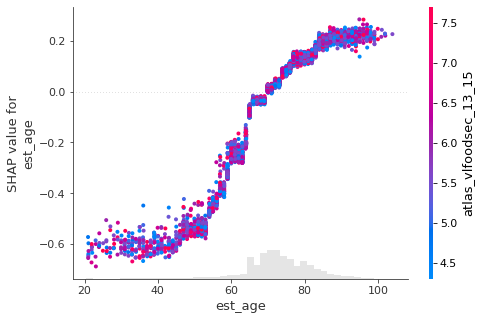

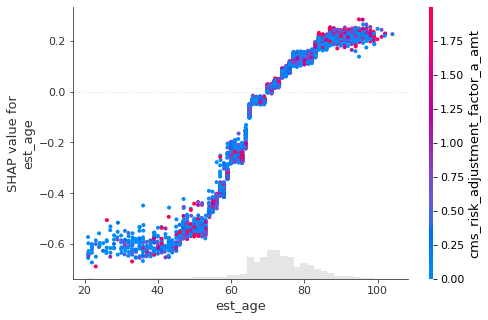

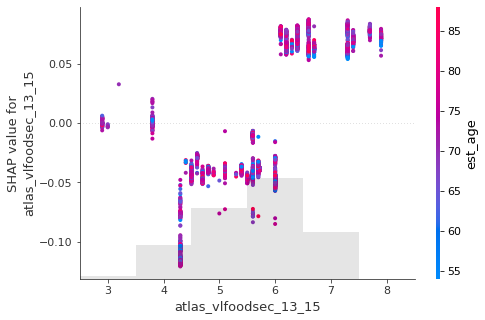

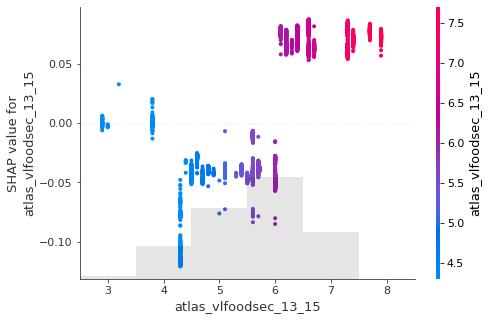

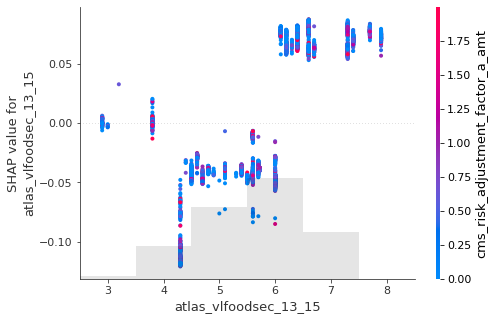

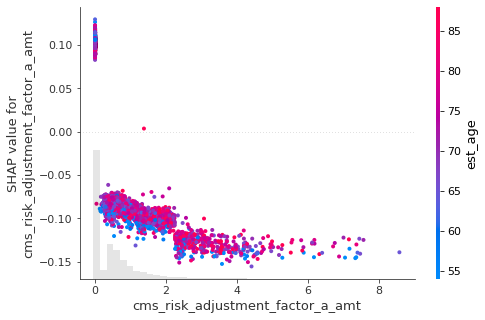

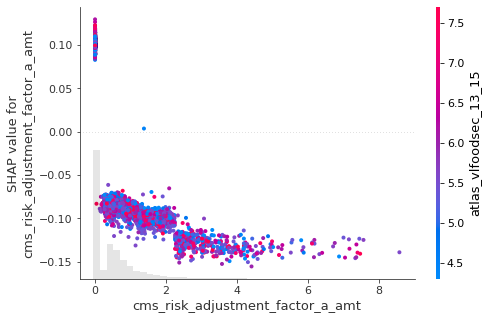

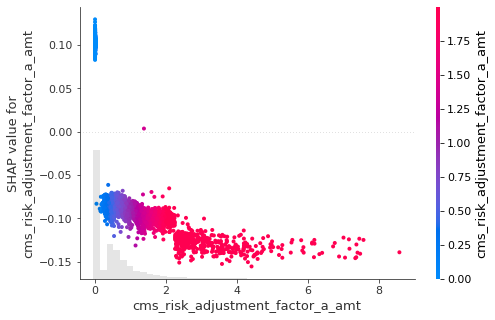

In [ ]:
shap.initjs()

for v1 in ['est_age','atlas_vlfoodsec_13_15','cms_risk_adjustment_factor_a_amt']:
    for v2 in ['est_age','atlas_vlfoodsec_13_15','cms_risk_adjustment_factor_a_amt']:
        shap.plots.scatter(shap_values[:,v1], color=shap_values[:,v2])

In [ ]:
df=pd.DataFrame((model_cat.feature_names_,model_cat.feature_importances_),index=['fea','imp']).T
df.sort_values('imp',ascending=False).set_index('fea').head(20).to_csv('fea_imp.csv')
# .plot(kind='bar')

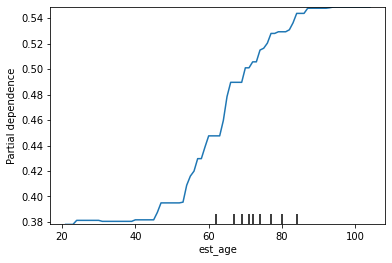

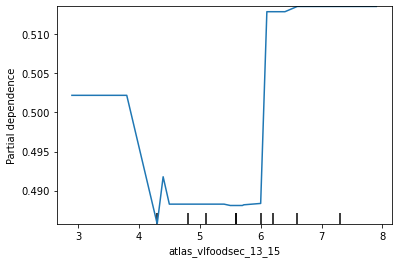

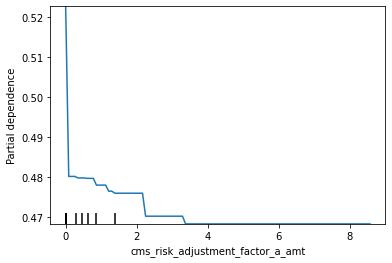

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt 


for var in ['est_age','atlas_vlfoodsec_13_15','cms_risk_adjustment_factor_a_amt']:
    fig=PartialDependenceDisplay.from_estimator(model_cat, test_data[:10000], [var], percentiles=(0,1))
    plt.savefig('pdp_%s.pdf'%var)

    fig=PartialDependenceDisplay.from_estimator(model_cat, test_data[:10000], [var],kind='individual')
    plt.savefig('ice_%s.pdf'%var)
